## Exploratory Data Analysis (EDA) for RetailRocket Dataset

### Import necessary modules

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Read in dataset files

#### Read in item_properties csv files

In [2]:
df1 = pd.read_csv('./data/item_properties_part1.csv')
df2 = pd.read_csv('./data/item_properties_part2.csv')
item_properties_df = pd.concat([df1, df2])
assert(len(item_properties_df) == 20275902)
item_properties_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


#### Read in events csv file

In [3]:
events_df = pd.read_csv('./data/events.csv')
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


#### Read in category_tree csv file

In [4]:
category_df = pd.read_csv('./data/category_tree.csv')
category_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


### Dataset examination

#### Item properties

##### Basic statistical info

In [5]:
item_properties_df.describe()

,timestamp,itemid
count,2.027590e+07,2.027590e+07
mean,1.435157e+12,2.333904e+05
std,3.327798e+09,1.348452e+05
min,1.431227e+12,0.000000e+00
25%,1.432436e+12,1.165160e+05
50%,1.433646e+12,2.334830e+05
75%,1.437880e+12,3.503040e+05
max,1.442113e+12,4.668660e+05


##### Number of duplicated/not available values

In [6]:
item_properties_df.duplicated().sum()

0

In [7]:
item_properties_df.isna().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

For item properties data, we have there are no duplicated properties or N/A properties, and so we are ready to use them directly. 

#### Events

##### Basic info

Since the variables in events dataframe are all categorical variables, we only provide the basic info here

In [8]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


##### Number of duplicated/not available values

In [9]:
events_df.duplicated().sum()

460

In [10]:
events_df.isna().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [11]:
events_df.isna().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

For events data, we have there are 460 number of duplicated events and many N/A values in `transactionid` column; this makes sense since the events are not distinct to each other and a transaction id will be NA if the event is not a transaction.

#### Category

##### Basic statistical info

In [12]:
category_df.describe()

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


##### Number of duplicated/not available values

In [13]:
category_df.duplicated().sum()

0

In [14]:
category_df.isna().sum()

categoryid     0
parentid      25
dtype: int64

For category data, we have there are no duplicated categories, yet there are several N/A `parentid` values, which indicates that some categories does not have a parent category, which is also reasonable since these categories can be the root categories of themselves.

### Feature Engineering & Exploration

#### Item Feature 1: Category ID

For recommending items in retail markets for certain users, the category of the item is definitely one important factor, as people will like things similar to other things they’ve previously liked. Therefore, the category id (hashed values due to confidential issues) can be used as a item feature in the recommendation system. 

The detailed instructions and code snippets of extracting category ID as the feature are shown below:

In [15]:
# Find the data of category ID of each item from item_properties
category_data = item_properties_df[item_properties_df['property'] == 'categoryid'][['itemid', 'value']]
category_data.rename(columns={'value':'category_id', 'itemid':'item_id'}, inplace=True)

# Match the category ID and item ID for each item in each event in sorted events  
sorted_events = pd.read_pickle(os.path.join('./data', 'sorted_events.df'))
merged_df = pd.merge(sorted_events, category_data, on='item_id', how='left')
merged_df['category_id'].fillna(-1, inplace=True)

# Only keep the item ID and category ID with removing duplicates
result_df = merged_df[['item_id', 'category_id']]
result_df = result_df.drop_duplicates(subset=['item_id', 'category_id'])
result_df = result_df[['item_id', 'category_id']].astype({'category_id': int})

#### Item Feature 2: Popularity of items based on events

The popularity of each item in the retail market is always one of the most important factors for users to consider; the more popular the item it is, the more likely will the item being chosen by customers. Therefore, using popularity of items would be a good choice for the recommendation system.

The detailed instructions and code snippets of extracting popularity of items based on events as the feature are shown below:

In [16]:
# Assign weights to each event type
event_weights = {'view': 1, 'addToCart': 10, 'transaction': 100}

# Calculate the weighted popularity of each item
item_popularity = events_df.groupby('itemid')['event'].apply(lambda x: sum(event_weights.get(e, 0) for e in x)).reset_index(name='popularity')
item_popularity.rename(columns={'itemid':'item_id'}, inplace=True)

# Left join based on the item_id
result_df = result_df.merge(item_popularity, on='item_id', how='left')

# Fill NA values with 0
result_df.fillna(0, inplace=True)

#### Item Feature 3: Most frequent item property with the most recent timestamp

Similar to the popularity of each item, the most frequent & most recent item property in the retail market is also one important thing to customers; people will like things similar to other things they’ve previously liked, and people will also tend to choose the things that occurs more recently for most items with certain properties. Therefore, the frequency of item property and the emerge and active time of these certain items and their corresponding item properties would also be wise to include into the recommendation system.

The detailed instructions and code snippets of most frequent item property with the most recent timestamp as the feature are shown below:

In [17]:
# Convert timestamp to datetime format
item_properties_df['timestamp'] = pd.to_datetime(item_properties_df['timestamp'], unit='ms')

# Group by itemId and find the most frequent property with the most recent timestamp
most_frequent_properties = item_properties_df.groupby('itemid').apply(lambda x: x[x['timestamp'] == x['timestamp'].max()]['property'].value_counts().index[0]).reset_index(name='most_frequent_property')
most_frequent_properties.rename(columns={'itemid':'item_id'}, inplace=True)

# Left join based on the item_id
result_df = result_df.merge(most_frequent_properties, on='item_id', how='left')

# Fill NA values with -1 
result_df.fillna(-1, inplace=True)

# Replace 'available' to -2, 'categoryid' to -3 in most_frequent_property
result_df['most_frequent_property'] = result_df['most_frequent_property'].replace({'available': -2, 'categoryid': -3})

#### Item Feature 4: Average item popularity each week

Besides the overall popularity, the popularity across the whole time period is also a important factor, as most users' preferences or tastes may have changed as the time proceeds. The items that are liked and maked transactions on consistently throghout the time are definitely the items that are tried and tested, and so would possibly be liked by more customers. Therefore, including the popularity in a weekly basis into the recommendation system is certainly a wise decision.

The detailed instructions and code snippets of the average item popularity each week as the feature are shown below:

In [18]:
# Convert the timestamp column to datetime format
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

# Compute the popularity for each event
events_df['event_weighted'] = events_df['event'].map(event_weights)

# Group the events by week, visitor ID, and item ID and compute the total popularity for each group
item_popularity_each_week = events_df.groupby([pd.Grouper(key='timestamp', freq='W'), 'visitorid', 'itemid'])['event_weighted'].sum()

# Compute the average event weight for each group
item_popularity_each_week = item_popularity_each_week.groupby(['visitorid', 'itemid']).mean()

# Reset the index and remove visitorid column
item_popularity_each_week = item_popularity_each_week.reset_index()
item_popularity_each_week.drop(['visitorid'], axis=1, inplace=True)

# Compute final average by grouping itemids together and take average
item_popularity_each_week = item_popularity_each_week.groupby('itemid')['event_weighted'].mean()
item_popularity_each_week.rename_axis('item_id', inplace=True)
item_popularity_each_week.rename('weekly_popularity')

item_id
3         1.000000
4         1.000000
6         1.115385
9         1.000000
15        5.000000
            ...   
466861    2.467105
466862    1.000000
466863    1.000000
466864    1.353448
466867    1.000000
Name: weekly_popularity, Length: 235061, dtype: float64

In [19]:
# Left join based on the item_id
result_df = result_df.merge(item_popularity_each_week, on='item_id', how='left')

# Fill NA values with 0 
result_df.fillna(0, inplace=True)

# Rename the newly added column
result_df.columns = ['item_id', 'category_id', 'popularity', 'most_frequent_properties', 'weekly_popularity']

#### Exploration

To ensure that each feature can effectively contribute to the final recommendation, all numerical features must ideally be independent to each other, or it will result in the collinearity problem that negatively impacts the recommendation model. Therefore, we perform a correlation check on all numerical features to see if there exists highly correlated features; if so, these features contains redundant information and we choose to remove some of them to ensure accuarcy.

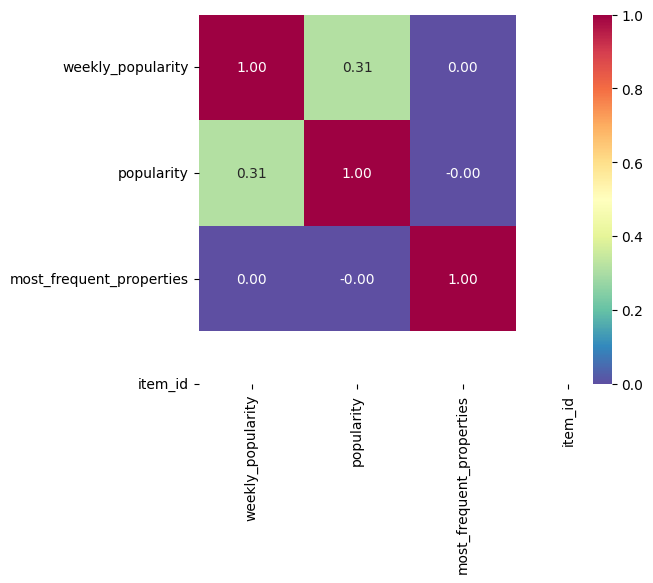

In [20]:
df = result_df[['weekly_popularity', 'popularity', 'most_frequent_properties', 'item_id']] # item_id and category_id are both categorical features
corrmat = df.corr(numeric_only=True)
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=df.columns, 
                 xticklabels=df.columns, 
                 cmap="Spectral_r")
plt.show()

From the correlation matrix heat map above, we can figure out that for all numerical features, only the **average popularity per week feature** and the **overall popularity feature** has weakly correlations, and the **most frequent & most recent item property feature** here has almost no correlation with any of the other two features. Therefore, we can choose to either include all these features or remove one of the features from **average popularity per week feature** and the **overall popularity feature** for our recommendation model training process.

### Browse & save the pre-processed data

In [21]:
result_df.head(10)

,item_id,category_id,popularity,most_frequent_properties,weekly_popularity
0,43511,1179,0.0,888,0.00
1,54408,209,5.0,189,1.25
2,10006,1694,7.0,765,1.00
3,49432,1280,1.0,888,1.00
4,39563,1196,6.0,348,1.20
5,32776,739,0.0,227,0.00
6,52161,1142,0.0,283,0.00
7,9750,227,0.0,888,0.00
8,38594,1325,1.0,227,1.00
9,52427,535,0.0,46,0.00


The first 10 rows of the pre-processed data is shown above, and the data can be saved into csv format by executing the code below.

In [22]:
result_df.to_csv('./retailrocket_item_features.csv', index=False)